Installing the necessary dependencies

In [1]:
!pip install ktrain

In [2]:
 !git clone https://github.com/laxmimerit/IMDB-Movie-Reviews-Large-Dataset-50k.git

fatal: destination path 'IMDB-Movie-Reviews-Large-Dataset-50k' already exists and is not an empty directory.


Importing the libraries

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import ktrain
from ktrain import text

Data Preparation:
I've loaded the training and test data from Excel files (train.xlsx and test.xlsx).
The training data contains movie reviews in the ‘Reviews’ column and corresponding sentiment labels in the ‘Sentiment’ column.

In [4]:
 data_train = pd.read_excel('/content/IMDB-Movie-Reviews-Large-Dataset-50k/train.xlsx', dtype=str)

In [5]:
 data_train

,Reviews,Sentiment
0,"When I first tuned in on this morning news, I ...",neg
1,"Mere thoughts of ""Going Overboard"" (aka ""Babes...",neg
2,Why does this movie fall WELL below standards?...,neg
3,Wow and I thought that any Steven Segal movie ...,neg
4,"The story is seen before, but that does'n matt...",neg
...,...,...
24995,Everyone plays their part pretty well in this ...,pos
24996,It happened with Assault on Prescient 13 in 20...,neg
24997,My God. This movie was awful. I can't complain...,neg
24998,"When I first popped in Happy Birthday to Me, I...",neg


In [6]:
data_test = pd.read_excel('/content/IMDB-Movie-Reviews-Large-Dataset-50k/test.xlsx', dtype=str)

In [7]:
data_test

,Reviews,Sentiment
0,Who would have thought that a movie about a ma...,pos
1,After realizing what is going on around us ......,pos
2,I grew up watching the original Disney Cindere...,neg
3,David Mamet wrote the screenplay and made his ...,pos
4,"Admittedly, I didn't have high expectations of...",neg
...,...,...
24995,This fanciful horror flick has Vincent Price p...,neg
24996,"The Intruder (L'Intrus), a film directed by Fr...",pos
24997,Holy crap. This was the worst film I have seen...,neg
24998,Clocking in at an interminable three hours and...,neg


Text Preprocessing:
I've used ktrain to preprocess the text data.
The maximum sequence length for the reviews is set to 500 tokens.
The preprocessing mode is set to ‘bert’.

In [8]:
(X_train, y_train), (X_test, y_test), preprocess = text.texts_from_df(train_df = data_train,
                                                                      text_column = 'Reviews',
                                                                      label_columns = 'Sentiment',
                                                                      val_df = data_test,
                                                                      maxlen = 500,
                                                                      preprocess_mode = 'bert')

['neg', 'pos']
   neg  pos
0  1.0  0.0
1  1.0  0.0
2  1.0  0.0
3  1.0  0.0
4  1.0  0.0
['neg', 'pos']
   neg  pos
0  0.0  1.0
1  0.0  1.0
2  1.0  0.0
3  0.0  1.0
4  1.0  0.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [9]:
X_train[0].shape

(25000, 500)

Model Creation:
I’ve created a sentiment analysis model using the BERT architecture.
The model is named ‘bert’.
It’s trained on the preprocessed training data.

In [10]:
model = text.text_classifier(name = 'bert',
                             train_data = (X_train, y_train),
                             preproc = preprocess)

Is Multi-Label? False
maxlen is 500


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


Model Training:
I've used a one-cycle learning rate schedule to train the model.
The learning rate was found using the lr_find() method.
The optimal learning rate was chosen based on the plot of learning rates.
The model was trained for one epoch with a batch size of 6.

In [11]:
learner = ktrain.get_learner(model = model,
                             train_data = (X_train, y_train),
                             val_data = (X_test, y_test),
                             batch_size = 6)

In [12]:
learner.lr_find()
learner.lr.plot()

In [13]:
learner.fit_onecycle(lr = 2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
4167/4167 [==============================] - ETA: 0s - loss: 0.2515 - accuracy: 0.8960

KeyboardInterrupt: ignored

In [15]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

I've saved the midel for furture use

In [16]:
predictor.save('/content/bert')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
X_test = data_test['Reviews'].tolist()
y_pred = predictor.predict(X_test)

Model Evaluation:
I’ve used the trained model to make predictions on the test data.
The predictions were converted to binary labels (1 for positive, 0 for negative).
The confusion matrix was computed to evaluate the model’s performance.
Precision, recall, and F1-score were calculated.

In [27]:
from sklearn.metrics import confusion_matrix

y_pred_binary = [1 if label == 'pos' else 0 for label in y_pred]

cm = confusion_matrix(y_test[:, 1], y_pred_binary)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[12006   494]
 [  317 12183]]


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test[:, 1], y_pred_binary)
recall = recall_score(y_test[:, 1], y_pred_binary)
f1 = f1_score(y_test[:, 1], y_pred_binary)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

Precision: 0.961
Recall: 0.975
F1-Score: 0.968


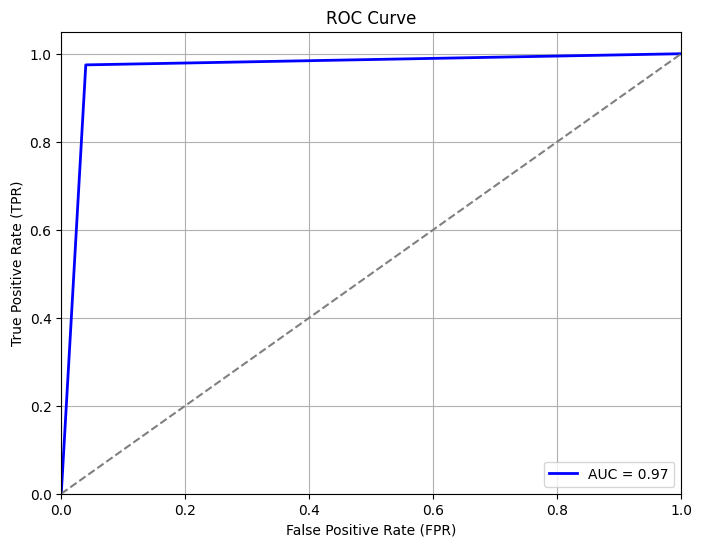

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_binary = [1 if label == 'pos' else 0 for label in y_pred]

fpr, tpr, _ = roc_curve(y_test[:, 1], y_pred_binary)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Results:
The confusion matrix provides insights into true positives, true negatives, false positives, and false negatives.
Recall (sensitivity) measures the proportion of actual positive cases correctly predicted by the model.
F1-score balances precision and recall.